## Simple Fixation Map training (2 layers)
with clutter / whitening

In [2]:
%matplotlib inline

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import noise
import MotionClouds as mc

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [6]:
from LogGabor import LogGabor

In [7]:
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
whit = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

## Noise stuff

In [8]:
def MotionCloudNoise(sf_0=0.125, B_sf=3., alpha = .5):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha= alpha)
    
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z, env


### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

In [9]:
# TODO: passer les arguments par la ligne de commande
N_theta = 6
N_azimuth = 16
N_eccentricity = 8
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [10]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                psi = i_azimuth * np.pi * 2 / N_azimuth
                theta_ref = i_theta*np.pi/N_theta
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos(psi)
                y = N_Y/2 + r * np.sin(psi)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': theta_ref + psi, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel() * ecc

    return retina


#### Full encoding

In [87]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 16, 8, 2, 16384)


In [12]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1536, 16384)


In [13]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1536)


#### Orientation invariant power encoding (colliculus??)

In [14]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 8, 16384)


In [15]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(128, 16384)


In [16]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 128)


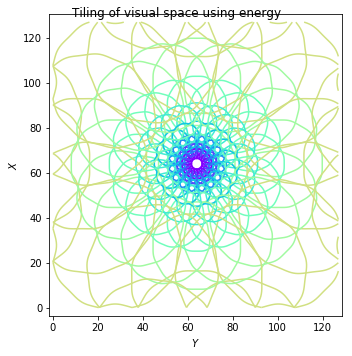

In [17]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

#### MNIST dataset read out

In [18]:
def get_data_loader(batch_size=100, train=True):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True)
    return data_loader


In [19]:
loader = get_data_loader(batch_size=100, train = False)

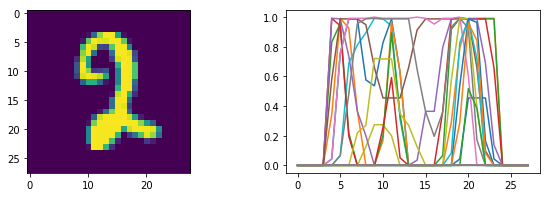

In [20]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

## Accuracy map

In [22]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


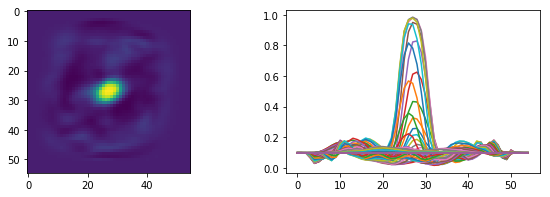

In [23]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy_map)
plt.subplot(122)
_ = plt.plot(accuracy_map)

### From MNIST encoding

#### Input vectors encoding

In [24]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=128, CONTRAST=1., NOISE = 1., sf_0 = 0.1, B_sf = 0.1):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= CONTRAST
    data_fullfield += 0.5

    if NOISE>0.:
        im_noise, _ = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf)
        im_noise = NOISE *  im_noise
        #data_fullfield += im_noise #randomized_perlin_noise() #
        indices_data = np.where(data_fullfield > data_fullfield.mean())
        im_noise[indices_data] = data_fullfield[indices_data]
        data_fullfield = im_noise
    
    whit.set_size((N_pic,N_pic))
    data_fullfield = whit.whitening(data_fullfield)

    data_retina = retina_vector @ np.ravel(data_fullfield)
    
    tensor_retina = data_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
    slice1 = tensor_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    slice2 = tensor_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    tensor_retina = np.concatenate ((slice1, tensor_retina, slice2), axis = 0)
    tensor_retina = np.transpose(tensor_retina,(3,0,1,2))

    return data_retina, tensor_retina, data_fullfield

In [25]:
def accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic=128):
    N_stim = accuracy_map.shape[0]
    center = (N_pic-N_stim)//2

    accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
    accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy_map

    accuracy_colliculus = colliculus_vector @ np.ravel(accuracy_fullfield)

    return accuracy_colliculus, accuracy_fullfield

0.9908850122863041

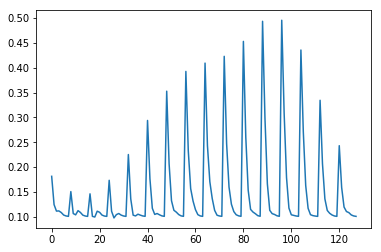

In [99]:
vec, _ = accuracy_fullfield(accuracy_map, 0,0)
_ = plt.plot(vec)
max(vec) * 2

#### Utilitaires

In [26]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

# Hyperparameters

In [63]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 15 #
OFFSET_MAX = 30 #
NOISE = 1 #0 #
CONTRAST = 0.3 #1 #
sf_0 = 0.2
B_sf = 0.3

### Test

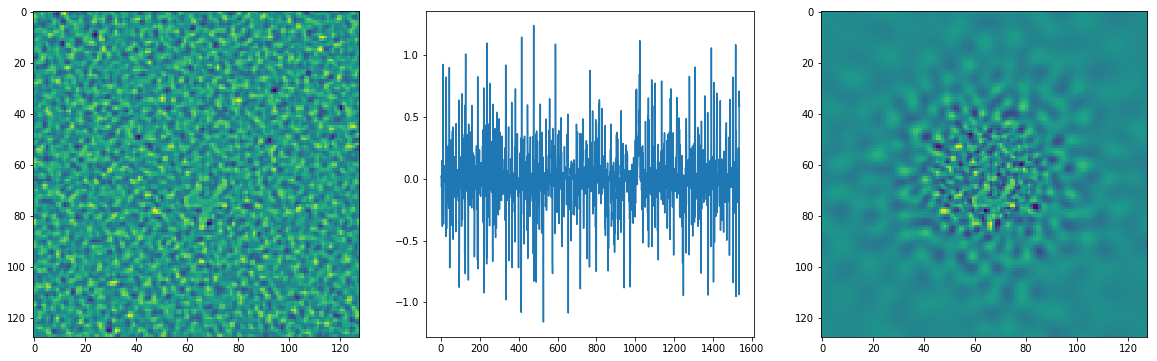

In [64]:
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    retina, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    f = plt.plot(retina)
    plt.subplot(133)
    im = retina_inverse @ retina
    plt.imshow(im.reshape(128, 128))


#### Torch stuff

In [65]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [66]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [67]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 200, bias = BIAS_DECONV)
        self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 1000, bias = BIAS_DECONV)
        #self.bn2 = torch.nn.Linear(200, 80, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(1000, 1000, bias = BIAS_DECONV)
        #self.bn3 = torch.nn.Linear(80, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(1000, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
                
    def forward(self, image):
       
        h_bn1 = F.relu(self.bn1(image))               
        h_bn2 = F.relu(self.bn2(h_bn1))
        h_bn2_drop = F.dropout(h_bn2, p = .5) 
        u = self.bn3(h_bn2_drop)
        
        return u


In [68]:
net = Net()

In [69]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [70]:
loss_func = torch.nn.BCEWithLogitsLoss() #torch.nn.CrossEntropyLoss()

In [71]:
#### Training

In [72]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        retina_data = np.zeros((minibatch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
        fixmap_data = np.zeros((minibatch_size, N_azimuth * N_eccentricity))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            retina_data[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                        CONTRAST = CONTRAST, NOISE = NOISE,
                                                        sf_0 = sf_0, B_sf = B_sf) 
            fixmap_data[i,:], _ = accuracy_fullfield(accuracy_map, i_offset, j_offset)
            

        retina_data = Variable(torch.FloatTensor(retina_data))
        fixmap_data = Variable(torch.FloatTensor(fixmap_data))
        
        prediction = net(retina_data)
        loss = loss_func(prediction, fixmap_data)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
                                                        
    return net


In [73]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
    fixmap_data = np.zeros((batch_size, N_azimuth * N_eccentricity))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        retina_data[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                                    sf_0 = sf_0, B_sf = B_sf)
        fixmap_data[i, :], _ = accuracy_fullfield(accuracy_map, i_offset, j_offset)


    retina_data = Variable(torch.FloatTensor(retina_data))
    fixmap_data = Variable(torch.FloatTensor(fixmap_data))
    
    with torch.no_grad():
        output = net(retina_data)
        loss = loss_func(output, fixmap_data)

    return loss.data.numpy()


## Anywhere target, with noise

#### Background noise + whitening

In [74]:
if True:
    for epoch in range(10):
        train(net, minibatch_size)
        loss = test(net)
        print('Test set: Final Loss: %.3f'%loss) 

Starting training...
[0/60000] Loss: 0.693333625793457 Time: 0.06 mn
[1000/60000] Loss: 0.6580512523651123 Time: 0.73 mn
[2000/60000] Loss: 0.5937382578849792 Time: 1.49 mn
[3000/60000] Loss: 0.4927845895290375 Time: 2.19 mn
[4000/60000] Loss: 0.40062215924263 Time: 2.87 mn
[5000/60000] Loss: 0.3595019280910492 Time: 3.78 mn
[6000/60000] Loss: 0.36148324608802795 Time: 4.58 mn
[7000/60000] Loss: 0.3647787570953369 Time: 5.36 mn
[8000/60000] Loss: 0.36235928535461426 Time: 6.13 mn
[9000/60000] Loss: 0.3566727936267853 Time: 6.87 mn
[10000/60000] Loss: 0.358224481344223 Time: 7.57 mn
[11000/60000] Loss: 0.3531324863433838 Time: 8.28 mn
[12000/60000] Loss: 0.3566064238548279 Time: 8.98 mn
[13000/60000] Loss: 0.35907450318336487 Time: 9.69 mn
[14000/60000] Loss: 0.34968265891075134 Time: 10.38 mn
[15000/60000] Loss: 0.35788363218307495 Time: 11.09 mn
[16000/60000] Loss: 0.3569372594356537 Time: 11.79 mn
[17000/60000] Loss: 0.35823512077331543 Time: 12.50 mn
[18000/60000] Loss: 0.3528263270

[31000/60000] Loss: 0.3515450954437256 Time: 21.72 mn
[32000/60000] Loss: 0.35364261269569397 Time: 22.41 mn
[33000/60000] Loss: 0.35351213812828064 Time: 23.11 mn
[34000/60000] Loss: 0.35204431414604187 Time: 23.81 mn
[35000/60000] Loss: 0.3554658889770508 Time: 24.51 mn
[36000/60000] Loss: 0.3506835401058197 Time: 25.22 mn
[37000/60000] Loss: 0.3508611023426056 Time: 25.92 mn
[38000/60000] Loss: 0.349980890750885 Time: 26.62 mn
[39000/60000] Loss: 0.35233062505722046 Time: 27.33 mn
[40000/60000] Loss: 0.3525135815143585 Time: 28.03 mn
[41000/60000] Loss: 0.3511517643928528 Time: 28.73 mn
[42000/60000] Loss: 0.3493175506591797 Time: 29.43 mn
[43000/60000] Loss: 0.3486168682575226 Time: 30.13 mn
[44000/60000] Loss: 0.3515971601009369 Time: 30.83 mn
[45000/60000] Loss: 0.352975457906723 Time: 31.53 mn
[46000/60000] Loss: 0.3550235331058502 Time: 32.23 mn
[47000/60000] Loss: 0.353471964597702 Time: 32.93 mn
[48000/60000] Loss: 0.34960049390792847 Time: 33.64 mn
[49000/60000] Loss: 0.3515

[1000/60000] Loss: 0.3479394316673279 Time: 0.77 mn
[2000/60000] Loss: 0.3539067208766937 Time: 1.47 mn
[3000/60000] Loss: 0.3516233265399933 Time: 2.17 mn
[4000/60000] Loss: 0.347293883562088 Time: 2.87 mn
[5000/60000] Loss: 0.3511318564414978 Time: 3.58 mn
[6000/60000] Loss: 0.3494042754173279 Time: 4.29 mn
[7000/60000] Loss: 0.3493477404117584 Time: 4.99 mn
[8000/60000] Loss: 0.3470974862575531 Time: 5.68 mn
[9000/60000] Loss: 0.3538985252380371 Time: 6.38 mn
[10000/60000] Loss: 0.34922441840171814 Time: 7.08 mn
[11000/60000] Loss: 0.35221949219703674 Time: 7.78 mn
[12000/60000] Loss: 0.34884724020957947 Time: 8.49 mn
[13000/60000] Loss: 0.35035714507102966 Time: 9.19 mn
[14000/60000] Loss: 0.3500722050666809 Time: 9.88 mn
[15000/60000] Loss: 0.35273995995521545 Time: 10.58 mn
[16000/60000] Loss: 0.3521670401096344 Time: 11.27 mn
[17000/60000] Loss: 0.3473484218120575 Time: 11.97 mn
[18000/60000] Loss: 0.3500988781452179 Time: 12.69 mn
[19000/60000] Loss: 0.35153892636299133 Time: 1

[32000/60000] Loss: 0.3489656150341034 Time: 22.53 mn
[33000/60000] Loss: 0.3491096496582031 Time: 23.23 mn
[34000/60000] Loss: 0.3501293957233429 Time: 23.92 mn
[35000/60000] Loss: 0.3506380617618561 Time: 24.62 mn
[36000/60000] Loss: 0.34857475757598877 Time: 25.33 mn
[37000/60000] Loss: 0.3517442047595978 Time: 26.02 mn
[38000/60000] Loss: 0.347190260887146 Time: 26.72 mn
[39000/60000] Loss: 0.3497063219547272 Time: 27.43 mn
[40000/60000] Loss: 0.34856364130973816 Time: 28.14 mn
[41000/60000] Loss: 0.3516847789287567 Time: 28.84 mn
[42000/60000] Loss: 0.34833136200904846 Time: 29.54 mn
[43000/60000] Loss: 0.3524823784828186 Time: 30.23 mn
[44000/60000] Loss: 0.34833070635795593 Time: 30.93 mn
[45000/60000] Loss: 0.350442498922348 Time: 31.63 mn
[46000/60000] Loss: 0.3484036922454834 Time: 32.32 mn
[47000/60000] Loss: 0.3489895462989807 Time: 33.02 mn
[48000/60000] Loss: 0.34993478655815125 Time: 33.72 mn
[49000/60000] Loss: 0.34680914878845215 Time: 34.42 mn
[50000/60000] Loss: 0.35

In [49]:
print('Test set: Final Loss: %.3f'%loss) 

Test set: Final Loss: 0.696


In [40]:
loss

array(0.6964472532272339, dtype=float32)

In [75]:
FIC_NAME = "2019-02-15-anywhere-background-noise-white-1000"
if True:
    torch.save(net, FIC_NAME + '.npy')
else:
    net = torch.load(FIC_NAME + '.npy')

# Visualisation

In [112]:
def accuracy_gain(prediction, fixmap_data, batch_size):
    indices_max = np.zeros(batch_size, dtype = 'int')
    for i in range(batch_size):
        indices_max[i] = np.where(prediction[i,:] == max(prediction[i,:]))[0][0]
    #acc = np.mean(fixmap_data.detach().numpy()[:,indices_max])
    acc = np.mean(fixmap_data[:,indices_max])
    return 0.1 + (acc - 0.1) * 2.25

In [113]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 20
test_loader = get_data_loader(batch_size=test_batch_size, train = False)

data, label = next(iter(test_loader))
input_ = np.zeros((test_batch_size, 1, vsize))
a_data = np.zeros((test_batch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

for idx in range(test_batch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_[idx, 0, :], _, _ = mnist_fullfield(data[idx, 0, :, :], i_offset, j_offset, 
                                            CONTRAST = CONTRAST, NOISE = NOISE,
                                            sf_0 = sf_0, B_sf = B_sf)
    a_data[idx, 0, :], _ = accuracy_fullfield(accuracy_map, i_offset, j_offset)

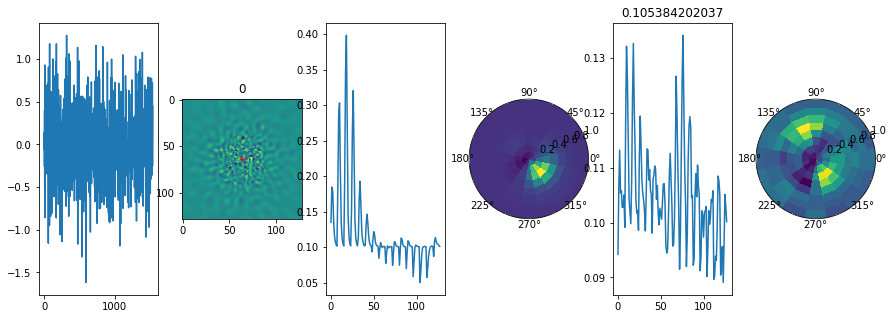

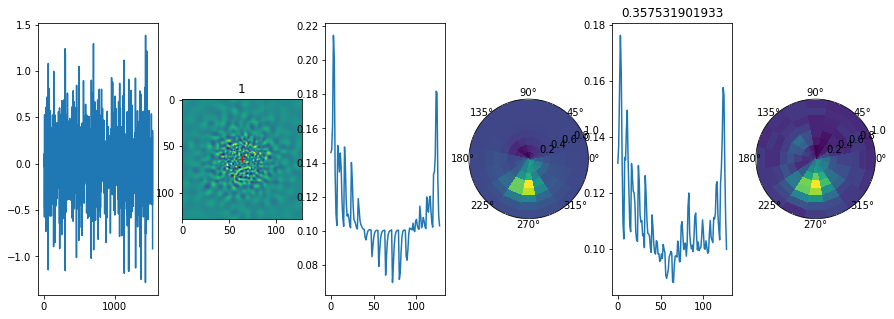

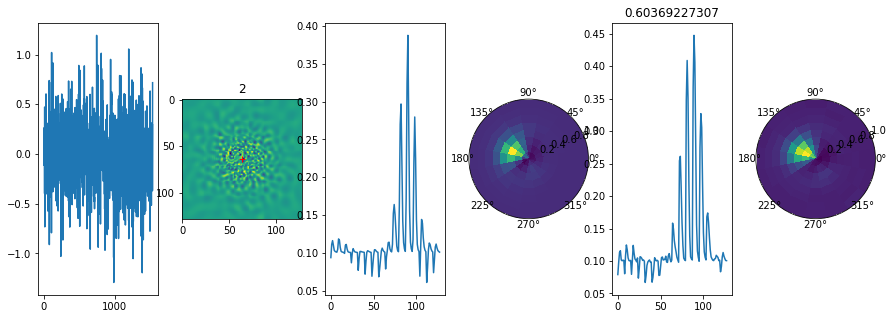

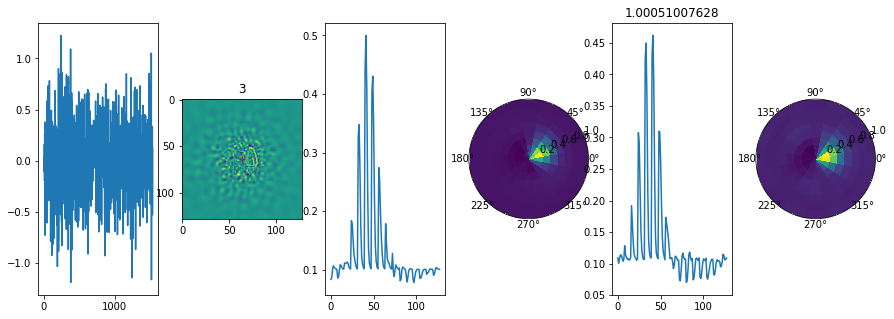

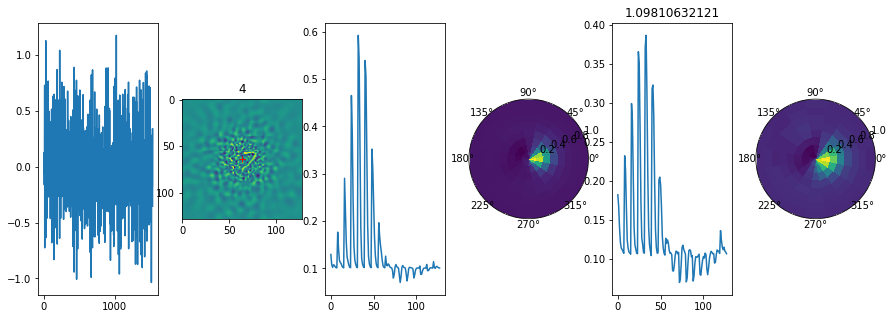

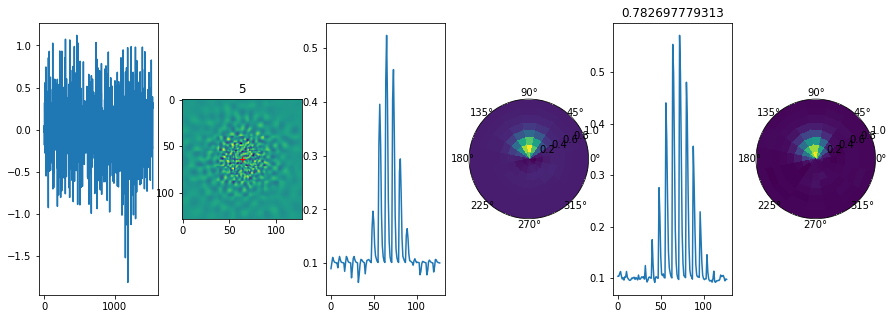

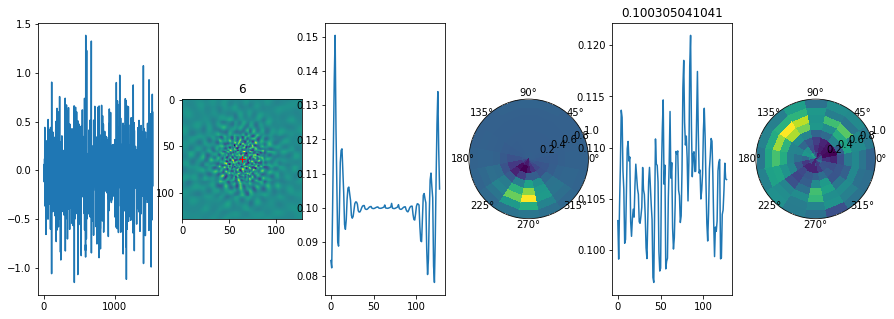

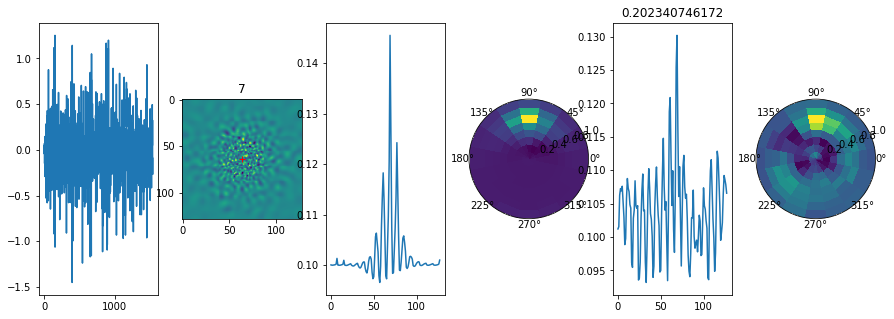

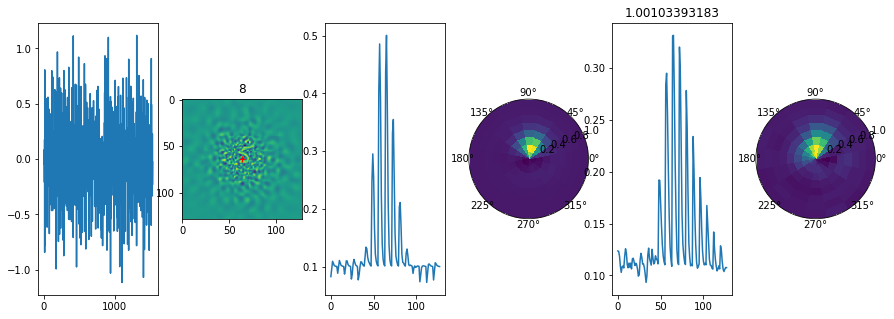

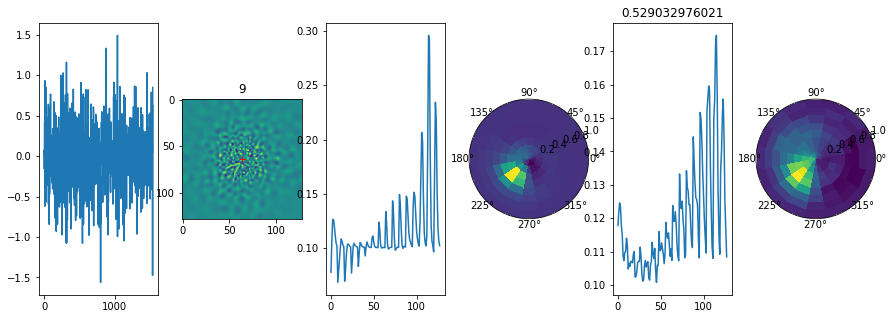

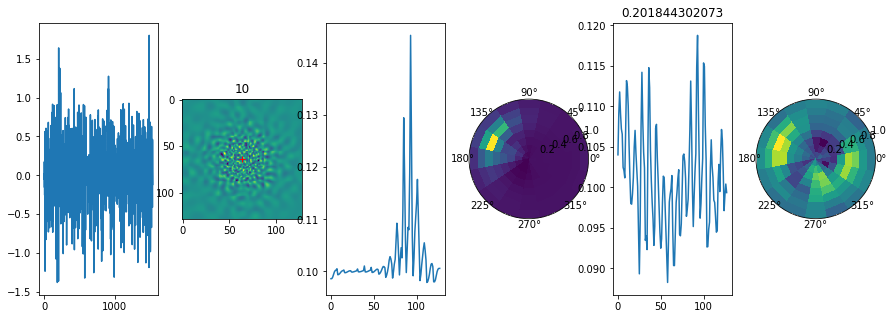

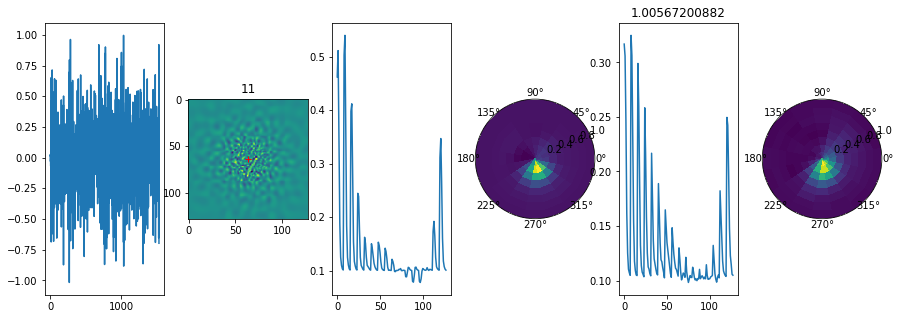

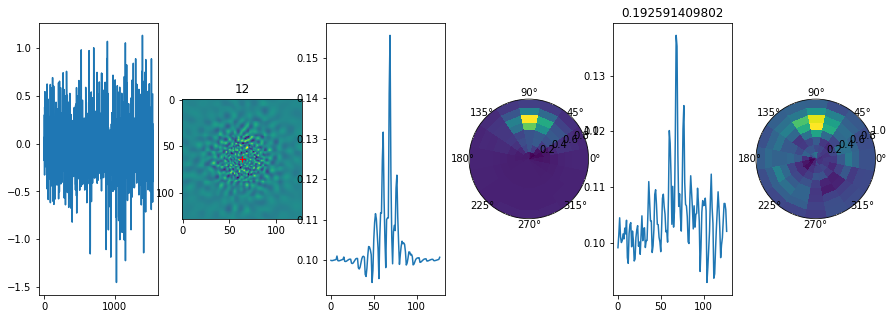

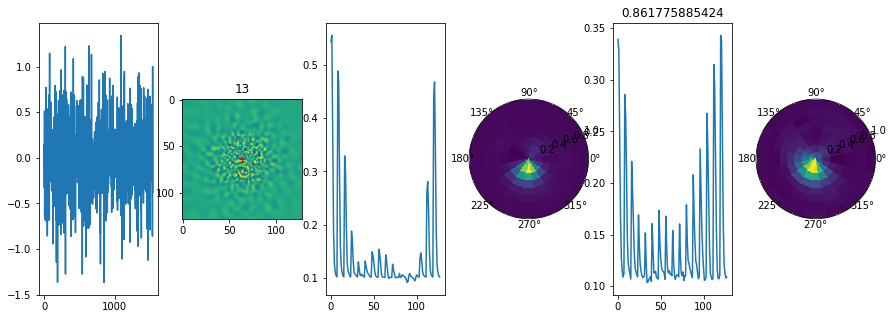

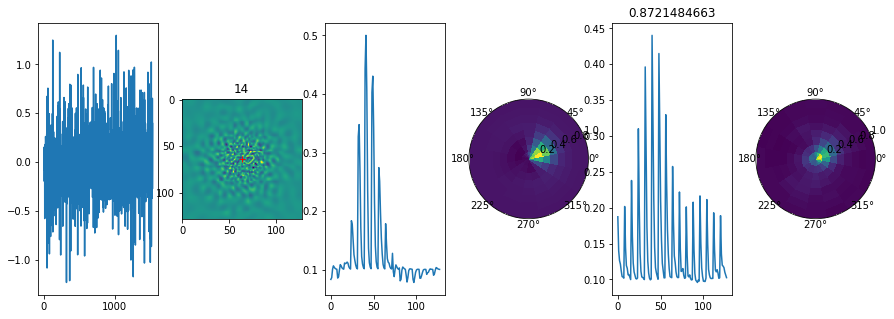

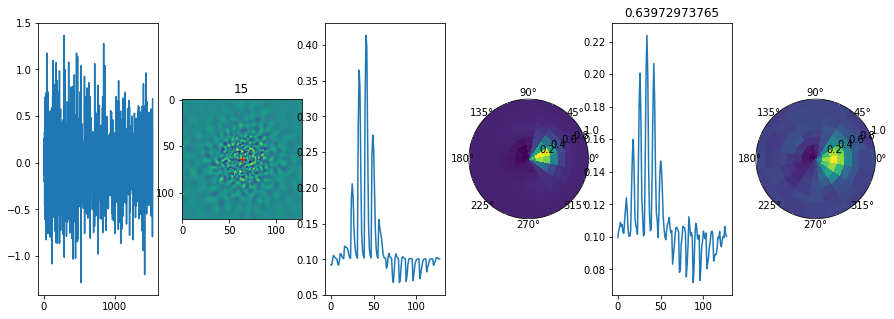

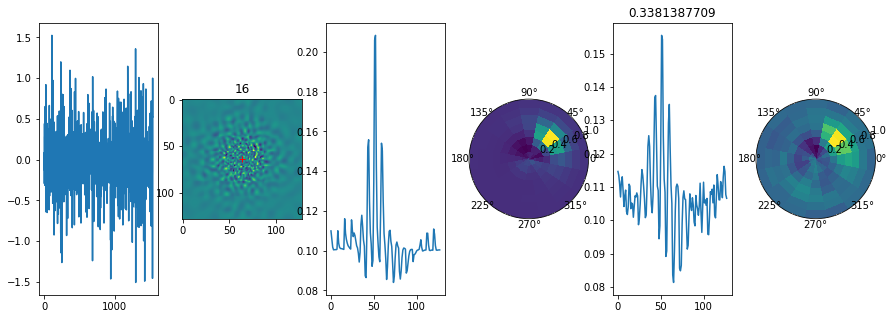

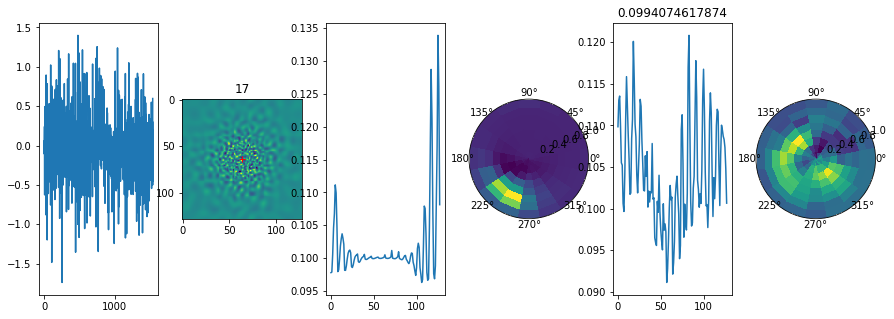

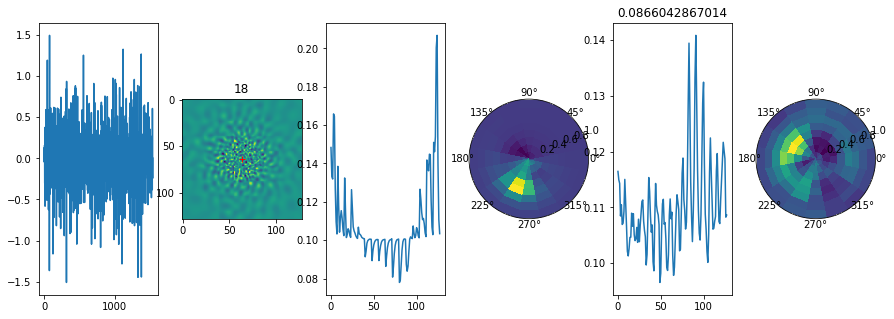

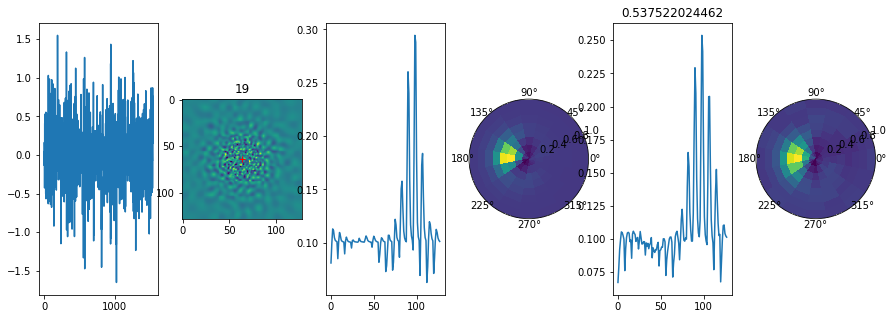

In [116]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for _ in range(test_batch_size):
    im = retina_inverse @ input_[_,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_[_,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.plot(63.5, 63.5, 'r+')
    plt.title(_)
    plt.subplot(163)
    plt.plot(a_data[_,0,:])    
    col = colliculus_inverse @ a_data[_,0,:]
    ax = plt.subplot(164, projection='polar')
    vec = a_data[_,0,:]
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_ = Variable(torch.FloatTensor(input_[_,0,:]))
    out = net(in_)
    acc = accuracy_gain(out.reshape(1,N_azimuth * N_eccentricity), vec.reshape(1,N_azimuth * N_eccentricity), 1)
    plt.subplot(165)
    out_sig = F.sigmoid(out).detach().numpy()
    plt.plot(out_sig)
    plt.title(acc)
    view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(view.reshape(128, 128))
                                 

In [83]:
indice_max = np.where(out_sig == np.max(out_sig))
indice_ref = np.where(vec == np.max(vec))
print(indice_max, indice_ref, vec[indice_max], vec[indice_ref])

(array([84]),) (array([85]),) [ 0.11221319] [ 0.13407009]


In [100]:
0.1 + (0.5-0.1) * 2.25

1.0

In [ ]:
N_eccentricity